In [6]:
# Attempt 1

Checking for NaN values in the dataset...
TSPAN6                                                                                                 0
TNMD                                                                                                   0
DPM1                                                                                                   0
SCYL3                                                                                                  0
C1orf112                                                                                               0
                                                                                                      ..
Bacteria;Actinobacteria;Actinobacteria;Actinomycetales;Mycobacteriaceae;Mycobacterium;arupense         0
Bacteria;Proteobacteria;Gammaproteobacteria;Pasteurellales;Pasteurellaceae;Gallibacterium;genomosp.    0
Bacteria;Actinobacteria;Actinobacteria;Actinomycetales;Mycobacteriaceae;Mycobacterium;celatum          0
Bacteria;Spir

/Users/schoudhry/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.0000e+00 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.0000e+00 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.0000e+00 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.0000e+00 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.0000e+00 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.0000e+00 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.0000e+00 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.0000e+00 - loss: nan - val_accuracy: 0.0000e+00 - 

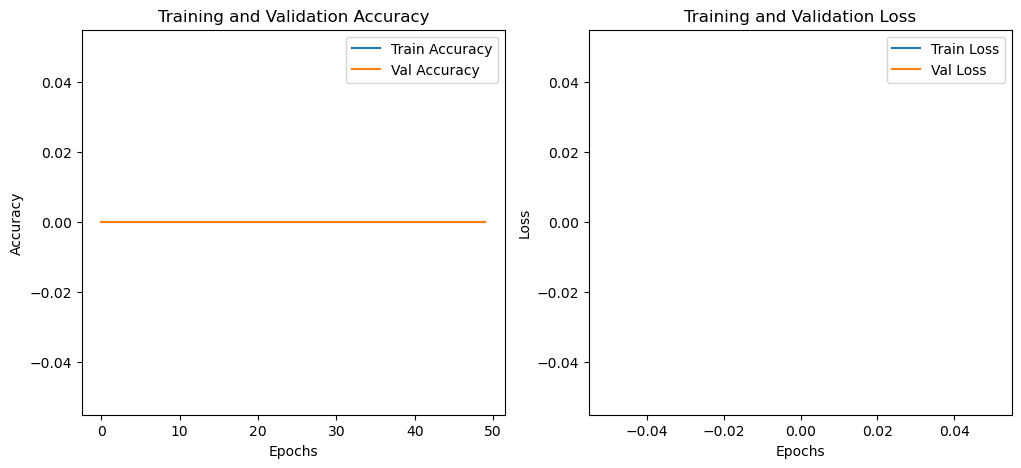

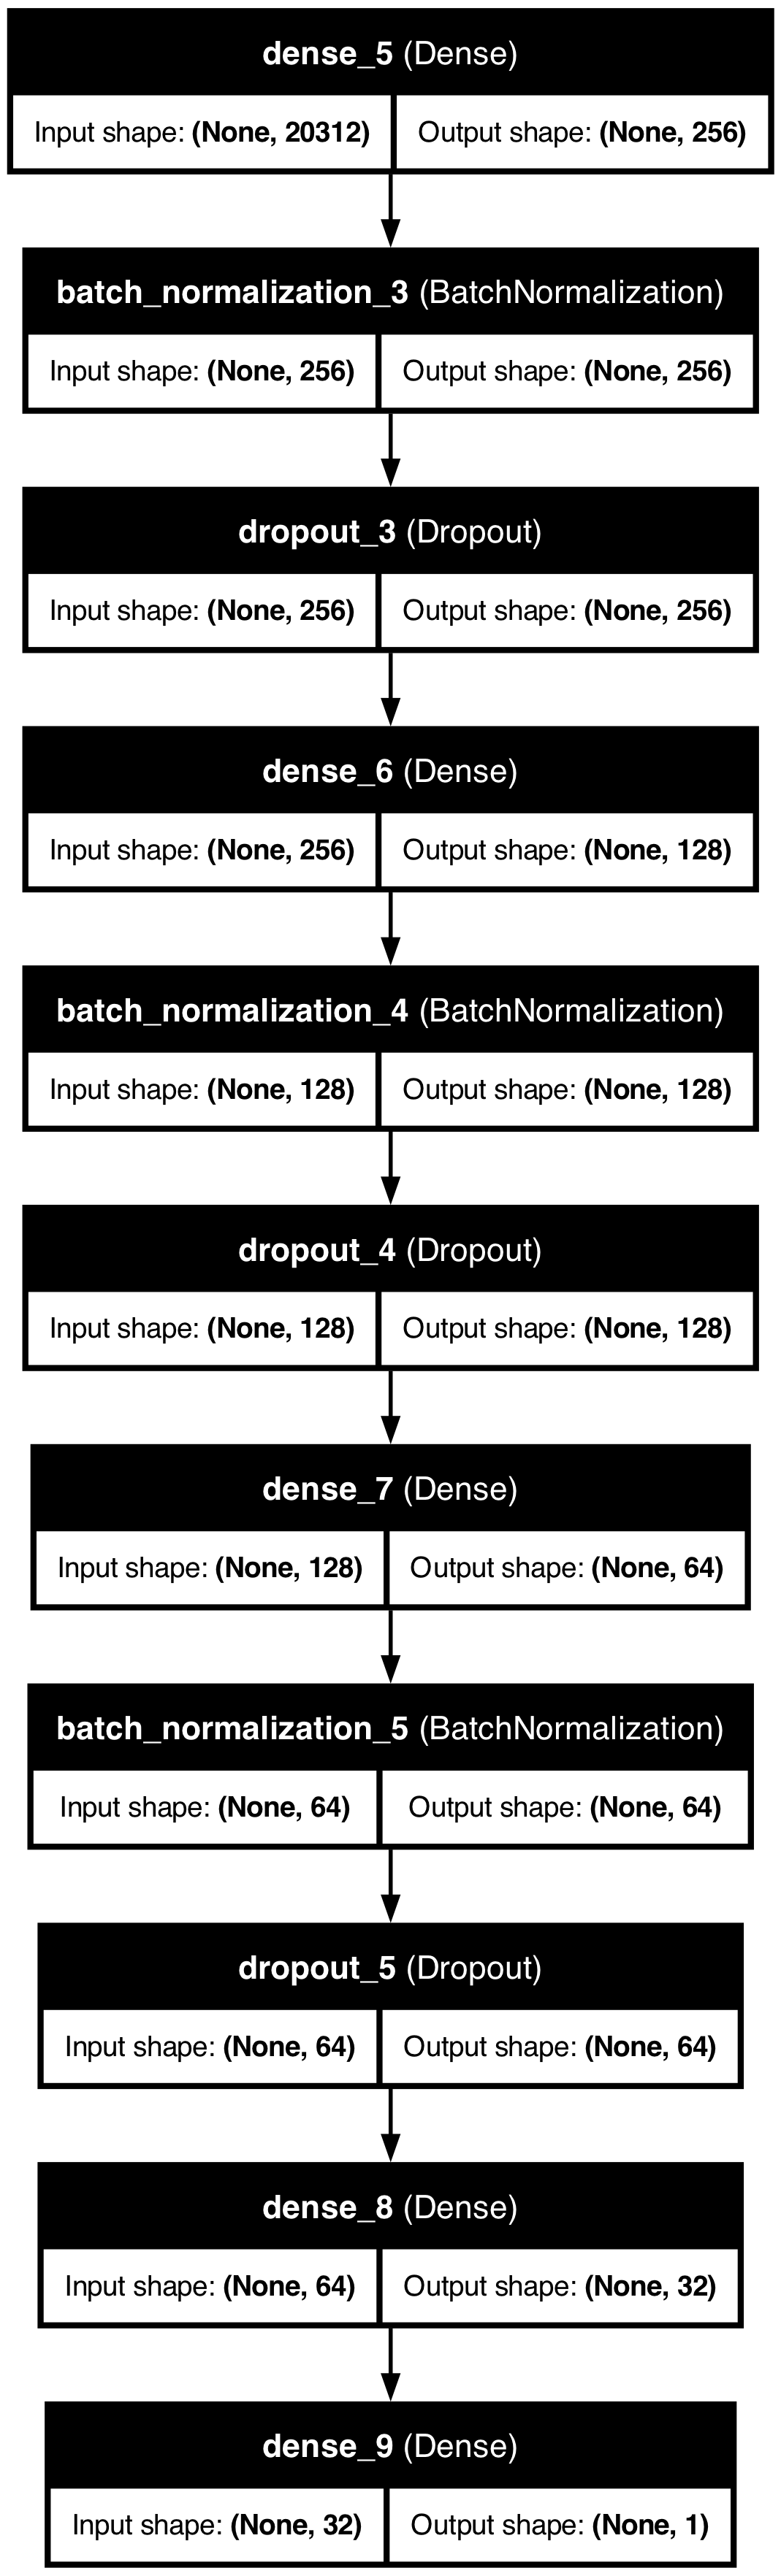

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt

csv12 = '/Users/schoudhry/Desktop/IIT/Research/researchData/StableS12.csv'
csv13 = '/Users/schoudhry/Desktop/IIT/Research/researchData/Stable13.csv'
csv1 = '/Users/schoudhry/Desktop/IIT/Research/researchData/Stable1.csv'

data_s12 = pd.read_csv(csv12)
data_s13 = pd.read_csv(csv13)
data_s1 = pd.read_csv(csv1)

patients = [f'B{str(i).zfill(2)}' for i in range(1, 27)]  # B01 to B26

genes_data = data_s12[['Unnamed: 0'] + patients].rename(columns={'Unnamed: 0': 'Gene'})  # Gene expression
bacteria_data = data_s13[['Unnamed: 0'] + patients].rename(columns={'Unnamed: 0': 'Bacteria'})  # Bacterial abundance

crc_status = data_s1[['Patient_Blind_ID', 'Description']].query("Patient_Blind_ID in @patients")
crc_status['CRC_Status'] = crc_status['Description'].apply(lambda x: 1 if x == 'tumor' else 0)

merged_data = pd.concat([genes_data.set_index('Gene').T, bacteria_data.set_index('Bacteria').T], axis=1)

merged_data = merged_data.apply(pd.to_numeric, errors='coerce')

print("Checking for NaN values in the dataset...")
print(merged_data.isnull().sum())  # Check for NaN values

# Handle missing values (fill NaNs with 0 or use a different strategy)
merged_data.fillna(0, inplace=True)

# Merge with CRC status
merged_data['CRC_Status'] = crc_status.set_index('Patient_Blind_ID')['CRC_Status']

X = merged_data.drop(columns=['CRC_Status']).values  # Features: gene and bacterial data
y = merged_data['CRC_Status'].values  # Target: CRC status (tumor or no tumor)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled = X_scaled.astype(np.float32)
y = y.astype(np.float32)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

model = tf.keras.Sequential([
    layers.InputLayer(input_shape=(X_train.shape[1],)),  # Input layer

    # First Dense Layer
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),  # Batch normalization for stable learning
    layers.Dropout(0.3),  # Dropout to prevent overfitting

    # Second Dense Layer
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    # Third Dense Layer
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    # Fourth Dense Layer
    layers.Dense(32, activation='relu'),

    # Output Layer (sigmoid for binary classification)
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f"Test Accuracy: {test_accuracy:.4f}")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()

from IPython.display import Image
Image('model_architecture.png')  # Shows the saved model plot


In [8]:
print(data_s1['Patient_Blind_ID'].unique())


[12337 12423  3600  3792  5691  3566  3874  4771 11808 12379 12372 13796
 14211  1762  1183  1343  1391  1457  1178  2093  1157  2186  2022  1944
  2567  2635  7647  2681  1200  1926  2216  1340  2343  1277  2840  1619
  4571  5741  4044  6470  6645  1552  8567  2853]


In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt

csv12 = '/Users/schoudhry/Desktop/IIT/Research/researchData/StableS12.csv'
csv13 = '/Users/schoudhry/Desktop/IIT/Research/researchData/Stable13.csv'
csv1 = '/Users/schoudhry/Desktop/IIT/Research/researchData/Stable1.csv'

data_s12 = pd.read_csv(csv12)
data_s13 = pd.read_csv(csv13)
data_s1 = pd.read_csv(csv1)

patients = [f'B{str(i).zfill(2)}' for i in range(1, 27)]  # B01 to B26

genes_data = data_s12[['Unnamed: 0'] + patients].rename(columns={'Unnamed: 0': 'Gene'})  # Gene expression
bacteria_data = data_s13[['Unnamed: 0'] + patients].rename(columns={'Unnamed: 0': 'Bacteria'})  # Bacterial abundance

crc_status = data_s1[['Patient_Blind_ID', 'Description']].query("Patient_Blind_ID in @patients")

crc_status['Patient_Blind_ID'] = crc_status['Patient_Blind_ID'].astype(str)

crc_status['CRC_Status'] = crc_status['Description'].apply(lambda x: 1 if x == 'tumor' else 0)

#Debugging: Print the shape of CRC status to make sure we are selecting the correct patients
print(f"CRC Status Shape: {crc_status.shape}")
print(crc_status.head())


merged_data = pd.concat([genes_data.set_index('Gene').T, bacteria_data.set_index('Bacteria').T], axis=1)

print(f"Merged Gene and Bacteria Data Shape: {merged_data.shape}")
print(merged_data.head())

merged_data = merged_data.apply(pd.to_numeric, errors='coerce')

print("Checking for NaN values in the dataset...")
print(merged_data.isnull().sum())  # Check for NaN values

merged_data.fillna(0, inplace=True)

# Debugging: Print the merged_data shape after filling NaN values
print(f"Shape after filling NaN values: {merged_data.shape}")

# Merge with CRC status (make sure index alignment is correct)
merged_data = merged_data.merge(crc_status.set_index('Patient_Blind_ID'), left_index=True, right_index=True)

# Debugging: Print the shape after merging with CRC status
print(f"Merged Data Shape after merging with CRC Status: {merged_data.shape}")
print(merged_data.head())

X = merged_data.drop(columns=['CRC_Status']).values  # Features: gene and bacterial data
y = merged_data['CRC_Status'].values  # Target: CRC status (tumor or no tumor)

# Debugging: Ensure that X and y have samples
print(f"X Shape: {X.shape}, y Shape: {y.shape}")

if X.shape[0] == 0:
    print("No samples available in the dataset after merging. Please check the data sources and merging logic.")
else:
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_scaled = X_scaled.astype(np.float32)
    y = y.astype(np.float32)

    # Step 10: Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    # Step 11: Define the neural network model
    model = tf.keras.Sequential([
        layers.InputLayer(input_shape=(X_train.shape[1],)),  # Input layer

        # First Dense Layer
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),  # Batch normalization for stable learning
        layers.Dropout(0.3),  # Dropout to prevent overfitting

        # Second Dense Layer
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        # Third Dense Layer
        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),

        # Fourth Dense Layer
        layers.Dense(32, activation='relu'),

        # Output Layer (sigmoid for binary classification)
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

    plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
    print(f"Test Accuracy: {test_accuracy:.4f}")

    plt.figure(figsize=(12, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.show()

    from IPython.display import Image
    Image('model_architecture.png')  # Show the saved model plot


CRC Status Shape: (0, 3)
Empty DataFrame
Columns: [Patient_Blind_ID, Description, CRC_Status]
Index: []
Merged Gene and Bacteria Data Shape: (26, 20312)
     TSPAN6  TNMD  DPM1  SCYL3  C1orf112  FGR   CFH  FUCA2  GCLC  NFYA  ...  \
B01     235    23   184    263        98  111  2291    243   608   325  ...   
B02     815    15   166    389        73  144   902    336   493   349  ...   
B03     351   188   146    185        69  370  2865    242   463   380  ...   
B04     629    12   124    231        70   53  1524    215   495   323  ...   
B05      91     4   150    480       457  287   299    259   458  1050  ...   

     Bacteria;Firmicutes;Bacilli;Lactobacillales;Streptococcaceae;Streptococcus;alactolyticus  \
B01                                                  3                                          
B02                                                  0                                          
B03                                                  0                           

In [10]:
# NOT WORKING ????


csv12 = '/Users/schoudhry/Desktop/IIT/Research/researchData/StableS12.csv'
csv13 = '/Users/schoudhry/Desktop/IIT/Research/researchData/Stable13.csv'
csv1 = '/Users/schoudhry/Desktop/IIT/Research/researchData/Stable1.csv'

# Load gene expression (S12), bacterial abundance (S13), and tumor/no tumor labels (S1)
data_s12 = pd.read_csv(csv12)
data_s13 = pd.read_csv(csv13)
data_s1 = pd.read_csv(csv1)


patients = [f'B{str(i).zfill(2)}' for i in range(1, 27)]  # B01 to B26

# Gene expression data
genes_data = data_s12[['Unnamed: 0'] + patients].rename(columns={'Unnamed: 0': 'Gene'})  # Gene expression

# Bacterial abundance data
bacteria_data = data_s13[['Unnamed: 0'] + patients].rename(columns={'Unnamed: 0': 'Bacteria'})  # Bacterial abundance


# Transpose the data so that patients are rows and genes/bacteria are columns
merged_data = pd.concat([genes_data.set_index('Gene').T, bacteria_data.set_index('Bacteria').T], axis=1)

crc_status = data_s1[['Tissue.RNA.DNA_Tube_ID', 'Description']].query("Tissue.RNA.DNA_Tube_ID in @patients")

# Convertin 'Description' to binary labels: 1 for tumor, 0 for normal
crc_status['CRC_Status'] = crc_status['Description'].apply(lambda x: 1 if x == 'tumor' else 0)

merged_data.index = patients  # Set patient IDs as index
merged_data = merged_data.merge(crc_status.set_index('Tissue.RNA.DNA_Tube_ID'), left_index=True, right_index=True)


X = merged_data.drop(columns=['CRC_Status']).values  # Features: gene and bacterial data
y = merged_data['CRC_Status'].values  # Target: CRC status (tumor or no tumor)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled = X_scaled.astype(np.float32)
y = y.astype(np.float32)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
#Define the neural network model(check)
model = tf.keras.Sequential([
    layers.InputLayer(input_shape=(X_train.shape[1],)),  # Input layer

    # First Dense Layer
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),  # Batch normalization for stable learning
    layers.Dropout(0.3),  # Dropout to prevent overfitting

    # Second Dense Layer
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    # Third Dense Layer
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    # Fourth Dense Layer
    layers.Dense(32, activation='relu'),

    # Output Layer (sigmoid for binary classification)
    layers.Dense(1, activation='sigmoid')
])

# Step 11: Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Step 12: Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Step 13: Visualize the model architecture using plot_model
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

# Step 14: Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Step 15: Plot training history (accuracy and loss)
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()

# Step 16: Display the saved model plot
from IPython.display import Image
Image('model_architecture.png')  # Show the saved model plot


UndefinedVariableError: name 'Tissue' is not defined

/var/folders/lt/fs9cxhhn7_v8qvhkq56m6zh80000gn/T/ipykernel_68583/3535686705.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crc_status['Tissue.RNA.DNA_Tube_ID'] = crc_status['Tissue.RNA.DNA_Tube_ID'].str.replace(' ', '')


Checking for NaN values in the dataset...
TSPAN6                                                                                            0
TNMD                                                                                              0
DPM1                                                                                              0
SCYL3                                                                                             0
C1orf112                                                                                          0
                                                                                                 ..
Bacteria;Actinobacteria;Actinobacteria;Actinomycetales;Mycobacteriaceae;Mycobacterium;celatum     0
Bacteria;Spirochaetes;GN05;LF030                                                                  0
Bacteria;Lentisphaerae;[Lentisphaeria];Z20;R4-45B                                                 0
Description                                               

/Users/schoudhry/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.4000 - loss: 0.9177 - val_accuracy: 0.8333 - val_loss: 0.5095
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.7000 - loss: 0.5273 - val_accuracy: 0.8333 - val_loss: 0.4908
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.7500 - loss: 0.4122 - val_accuracy: 0.8333 - val_loss: 0.4820
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9000 - loss: 0.2925 - val_accuracy: 0.8333 - val_loss: 0.4606
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.7500 - loss: 0.3767 - val_accuracy: 0.8333 - val_loss: 0.4284
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9500 - loss: 0.2407 - val_accuracy: 0.8333 - val_loss: 0.4040
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9500 - loss: 0.2603 - val_accuracy: 0.8333 - val_loss: 0.3913
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9000 - loss: 0.2985 - val_accuracy: 0.8333 - val_loss: 0.3848
Ep

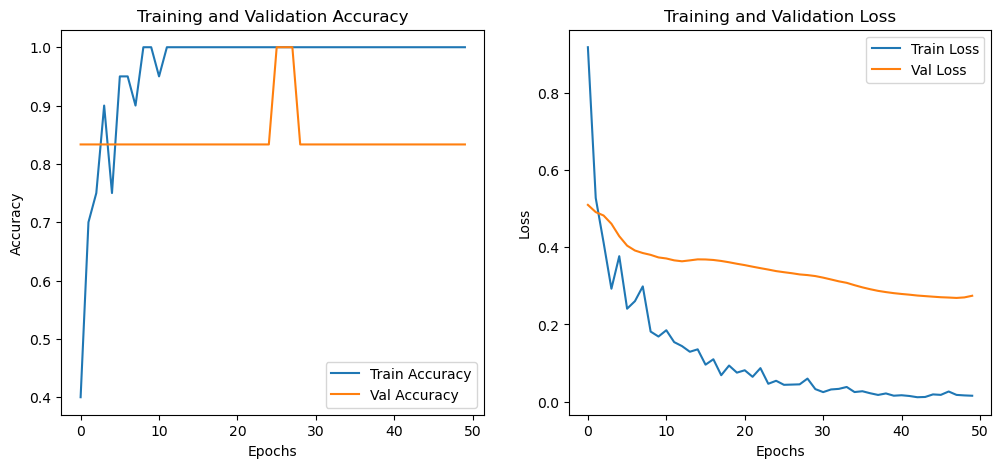

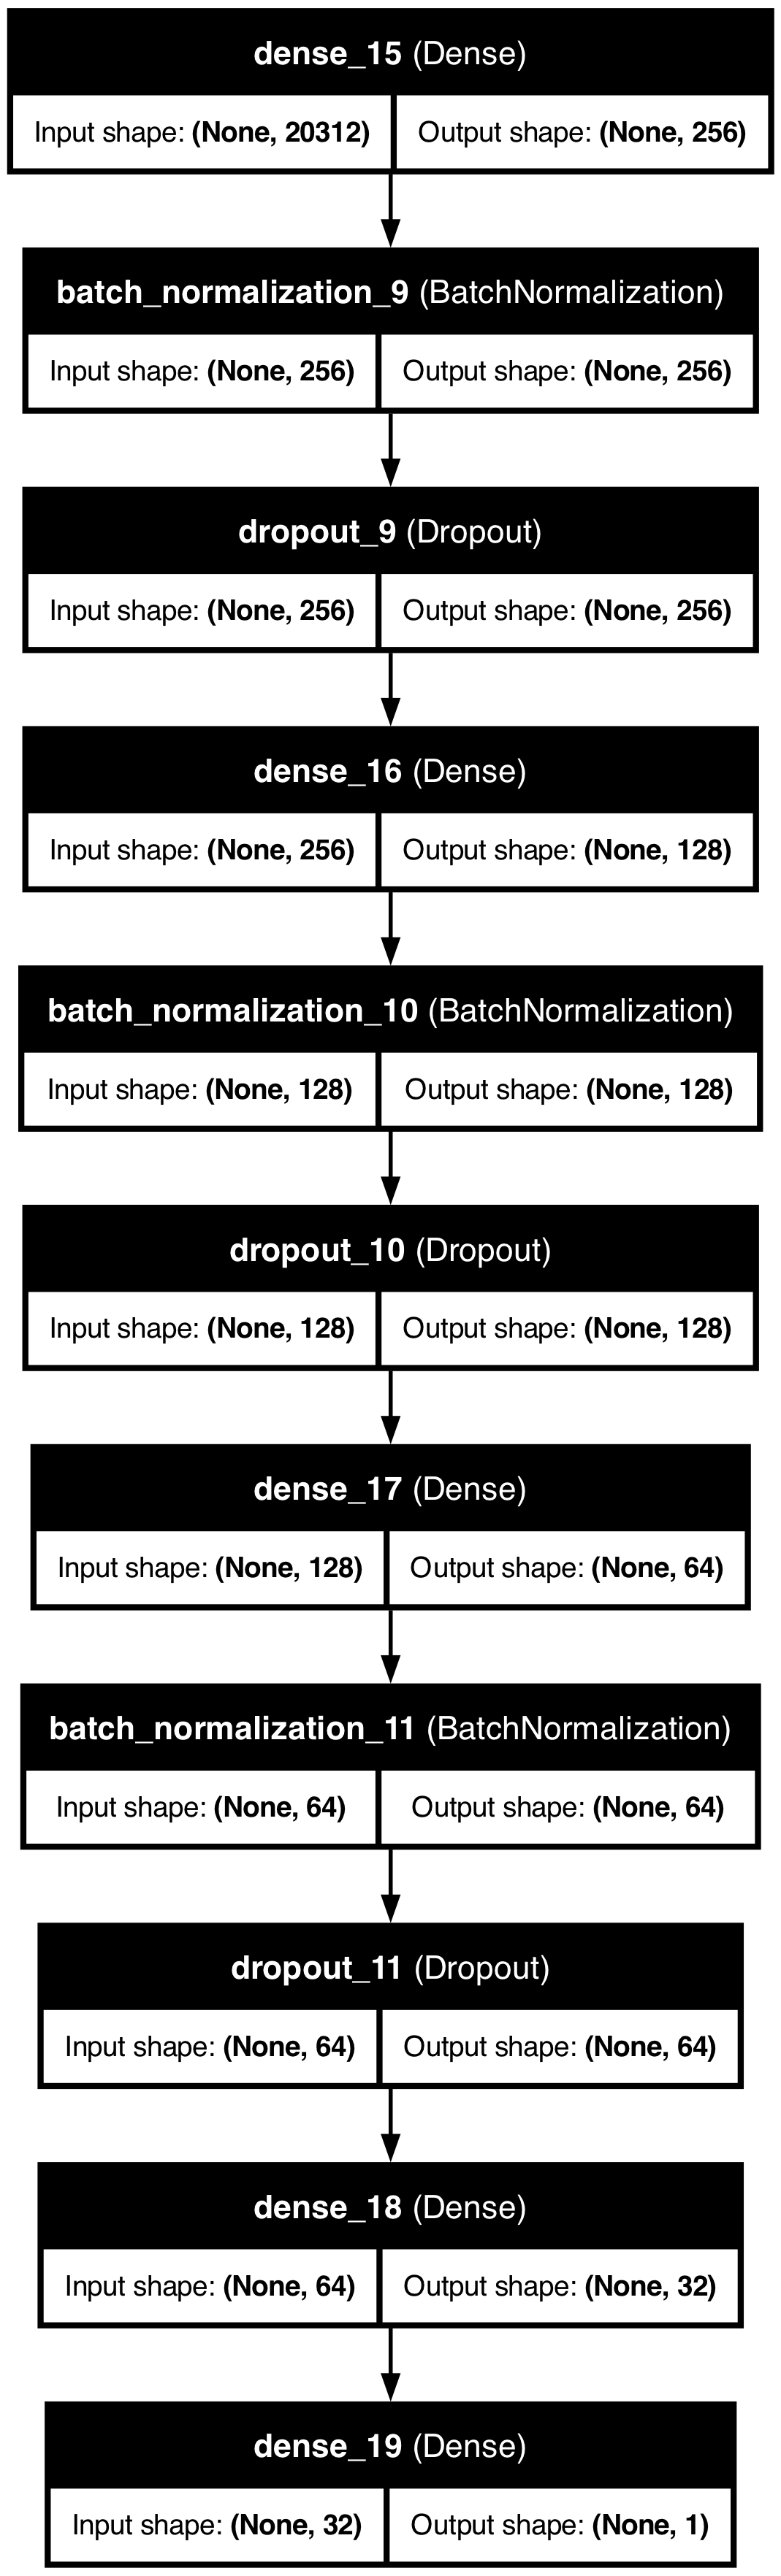

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt

csv12 = '/Users/schoudhry/Desktop/IIT/Research/researchData/StableS12.csv'
csv13 = '/Users/schoudhry/Desktop/IIT/Research/researchData/Stable13.csv'
csv1 = '/Users/schoudhry/Desktop/IIT/Research/researchData/Stable1.csv'

data_s12 = pd.read_csv(csv12)
data_s13 = pd.read_csv(csv13)
data_s1 = pd.read_csv(csv1)

patients = [f'B{str(i).zfill(2)}' for i in range(1, 27)]  # B01 to B26

genes_data = data_s12[['Unnamed: 0'] + patients].rename(columns={'Unnamed: 0': 'Gene'})  # Gene expression
bacteria_data = data_s13[['Unnamed: 0'] + patients].rename(columns={'Unnamed: 0': 'Bacteria'})  # Bacterial abundance

crc_status = data_s1[['Tissue.RNA.DNA_Tube_ID', 'Description']]  # Select the relevant columns

# Convert the 'Tissue.RNA.DNA_Tube_ID' to match B01, B02 format
crc_status['Tissue.RNA.DNA_Tube_ID'] = crc_status['Tissue.RNA.DNA_Tube_ID'].str.replace(' ', '')

# Filter crc_status for B01 to B26
crc_status = crc_status[crc_status['Tissue.RNA.DNA_Tube_ID'].isin(patients)]

# Convert 'Description' to binary labels: 1 for tumor, 0 for normal using .loc to avoid the warning
crc_status.loc[:, 'CRC_Status'] = crc_status['Description'].apply(lambda x: 1 if x == 'tumor' else 0)

merged_data = pd.concat([genes_data.set_index('Gene').T, bacteria_data.set_index('Bacteria').T], axis=1)

# Merge with CRC status based on matching the patient IDs
crc_status.index = crc_status['Tissue.RNA.DNA_Tube_ID']  # Set patient IDs as index
merged_data = merged_data.merge(crc_status.set_index('Tissue.RNA.DNA_Tube_ID'), left_index=True, right_index=True)

merged_data = merged_data.apply(pd.to_numeric, errors='coerce')

print("Checking for NaN values in the dataset...")
print(merged_data.isnull().sum())  # Check for NaN values

# Handle missing values (fill NaNs with 0 or use a different strategy)
merged_data.fillna(0, inplace=True)

X = merged_data.drop(columns=['CRC_Status', 'Description']).values  # Features: gene and bacterial data
y = merged_data['CRC_Status'].values  # Target: CRC status (tumor or no tumor)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled = X_scaled.astype(np.float32)
y = y.astype(np.float32)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

model = tf.keras.Sequential([
    layers.InputLayer(input_shape=(X_train.shape[1],)),  # Input layer

    # First Dense Layer
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),  # Batch normalization for stable learning
    layers.Dropout(0.3),  # Dropout to prevent overfitting

    # Second Dense Layer
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    # Third Dense Layer
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    # Fourth Dense Layer
    layers.Dense(32, activation='relu'),

    # Output Layer (sigmoid for binary classification)
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f"Test Accuracy: {test_accuracy:.4f}")

plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()


from IPython.display import Image
Image('model_architecture.png')  # Show the saved model plot

# Epoch documentation needs filtered updating

/var/folders/lt/fs9cxhhn7_v8qvhkq56m6zh80000gn/T/ipykernel_74637/1600101781.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crc_status['Tissue.RNA.DNA_Tube_ID'] = crc_status['Tissue.RNA.DNA_Tube_ID'].str.replace(' ', '')
/var/folders/lt/fs9cxhhn7_v8qvhkq56m6zh80000gn/T/ipykernel_74637/1600101781.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crc_status['CRC_Status'] = crc_status['Description'].apply(lambda x: 1 if x == 'tumor' else 0)


Epoch 1/50


/Users/schoudhry/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.4161 - loss: 1.1402 - val_accuracy: 0.8889 - val_loss: 0.2204
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6008 - loss: 0.5702 - val_accuracy: 0.8889 - val_loss: 0.2506
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7315 - loss: 0.5096 - val_accuracy: 0.8889 - val_loss: 0.2826
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6294 - loss: 0.4632 - val_accuracy: 0.8889 - val_loss: 0.2952
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8953 - loss: 0.3633 - val_accuracy: 0.8889 - val_loss: 0.2806
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9441 - loss: 0.3105 - val_accuracy: 0.8333 - val_loss: 0.2701
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9148 - loss: 0.2732 - val_accuracy: 0.9444 - val_loss: 0.2473
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9187 - loss: 0.2607 - val_accuracy: 0.9444 - val_loss: 0.2339
Epoch 9/50


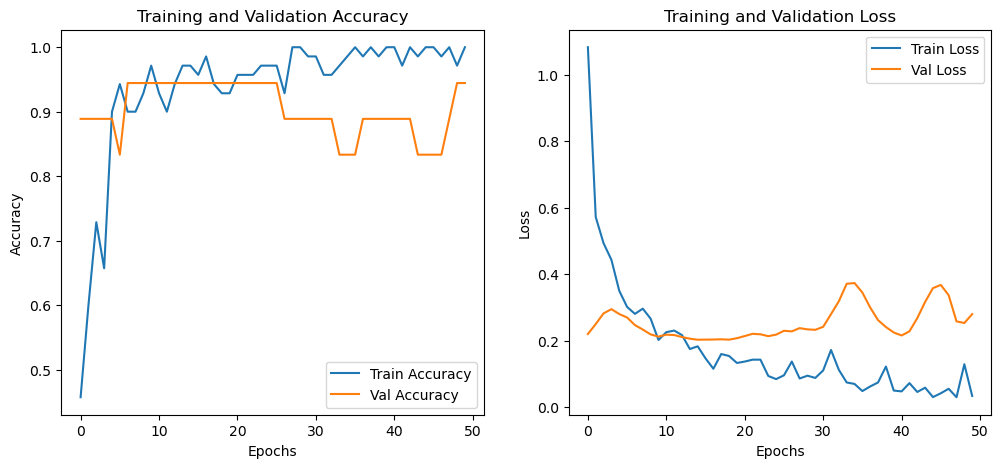

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


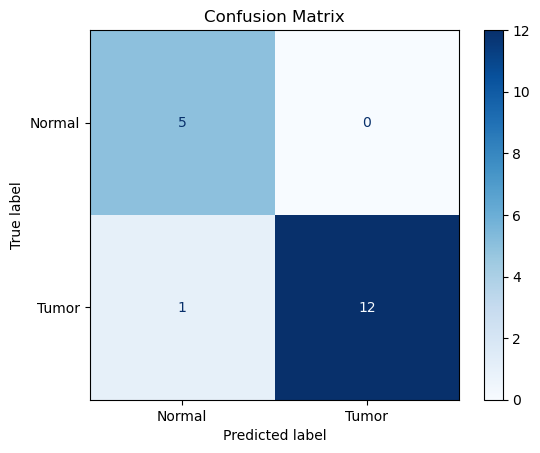

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


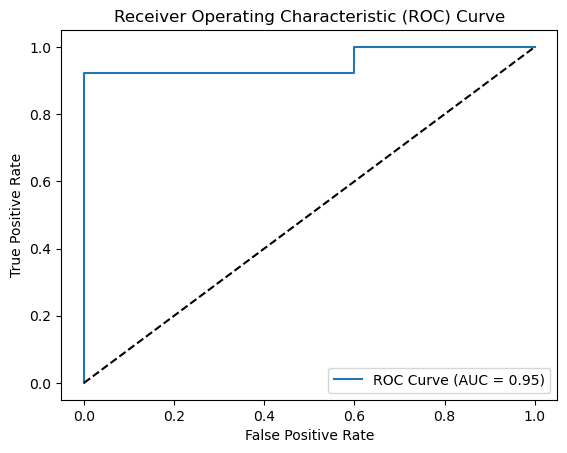

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import tensorflow as tf
from tensorflow.keras import layers # issue ?????
import matplotlib.pyplot as plt

genes_data = data_s12.rename(columns={'Unnamed: 0': 'Gene'})
all_patients_genes = genes_data.columns[1:]

bacteria_data = data_s13.rename(columns={'Unnamed: 0': 'Bacteria'})
all_patients_bacteria = bacteria_data.columns[1:]

crc_status = data_s1[['Tissue.RNA.DNA_Tube_ID', 'Description']]
crc_status['Tissue.RNA.DNA_Tube_ID'] = crc_status['Tissue.RNA.DNA_Tube_ID'].str.replace(' ', '')
crc_status['CRC_Status'] = crc_status['Description'].apply(lambda x: 1 if x == 'tumor' else 0)

merged_data = pd.concat([genes_data.set_index('Gene').T, bacteria_data.set_index('Bacteria').T], axis=1)
crc_status.index = crc_status['Tissue.RNA.DNA_Tube_ID']
merged_data = merged_data.merge(crc_status.set_index('Tissue.RNA.DNA_Tube_ID'), left_index=True, right_index=True)

merged_data = merged_data.apply(pd.to_numeric, errors='coerce')
merged_data.fillna(0, inplace=True)
X = merged_data.drop(columns=['CRC_Status', 'Description']).values
y = merged_data['CRC_Status'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = X_scaled.astype(np.float32)
y = y.astype(np.float32)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

model = tf.keras.Sequential([
    layers.InputLayer(input_shape=(X_train.shape[1],)),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f"Test Accuracy: {test_accuracy:.4f}")

plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()

y_pred = (model.predict(X_test) > 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Tumor'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, model.predict(X_test))
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


/var/folders/lt/fs9cxhhn7_v8qvhkq56m6zh80000gn/T/ipykernel_74637/3762558162.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crc_status['Tissue.RNA.DNA_Tube_ID'] = crc_status['Tissue.RNA.DNA_Tube_ID'].str.replace(' ', '')
/var/folders/lt/fs9cxhhn7_v8qvhkq56m6zh80000gn/T/ipykernel_74637/3762558162.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crc_status['CRC_Status'] = crc_status['Description'].apply(lambda x: 1 if x == 'tumor' else 0)
/Users/schoudhry/anaconda3/lib/python3.11/site-packages/keras/

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.5208 - loss: 0.9854 - val_accuracy: 0.7778 - val_loss: 0.7758
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7939 - loss: 0.4685 - val_accuracy: 0.7778 - val_loss: 0.6014
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7763 - loss: 0.4926 - val_accuracy: 0.8889 - val_loss: 0.4955
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8329 - loss: 0.4360 - val_accuracy: 0.8889 - val_loss: 0.3979
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9298 - loss: 0.2782 - val_accuracy: 0.8889 - val_loss: 0.3376
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8992 - loss: 0.3687 - val_accuracy: 0.8889 - val_loss: 0.2981
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8537 - loss: 0.3528 - val_accuracy: 0.8889 - val_loss: 0.2627
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9103 - loss: 0.2881 - val_accuracy: 0.8333 - val_loss: 0.2901


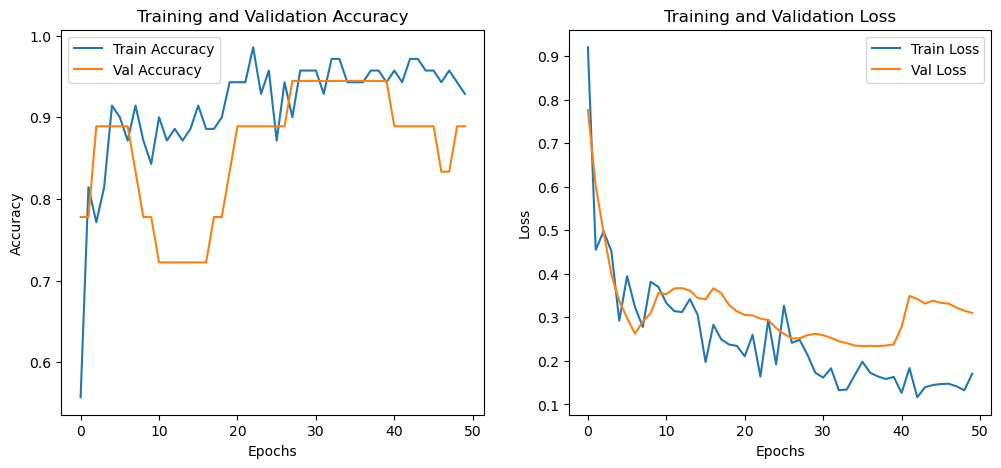

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


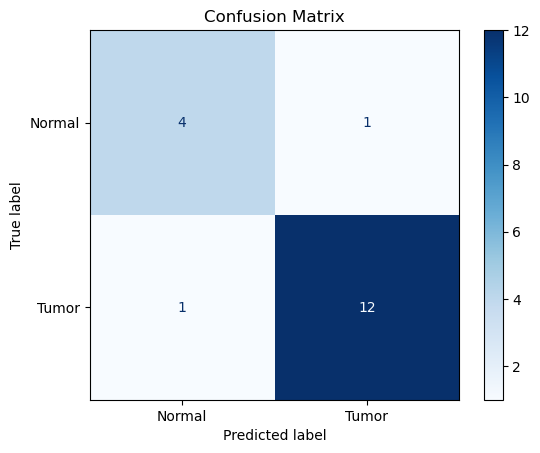

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


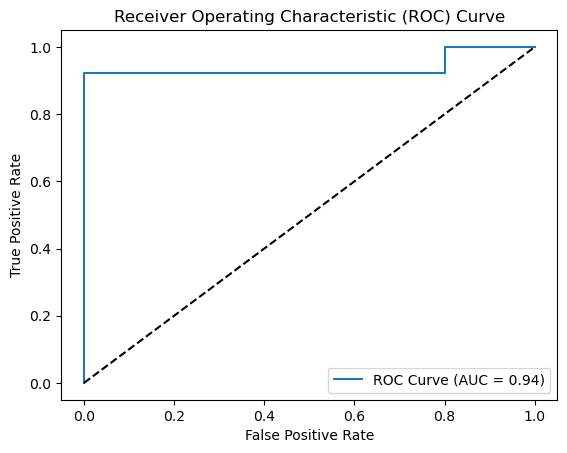

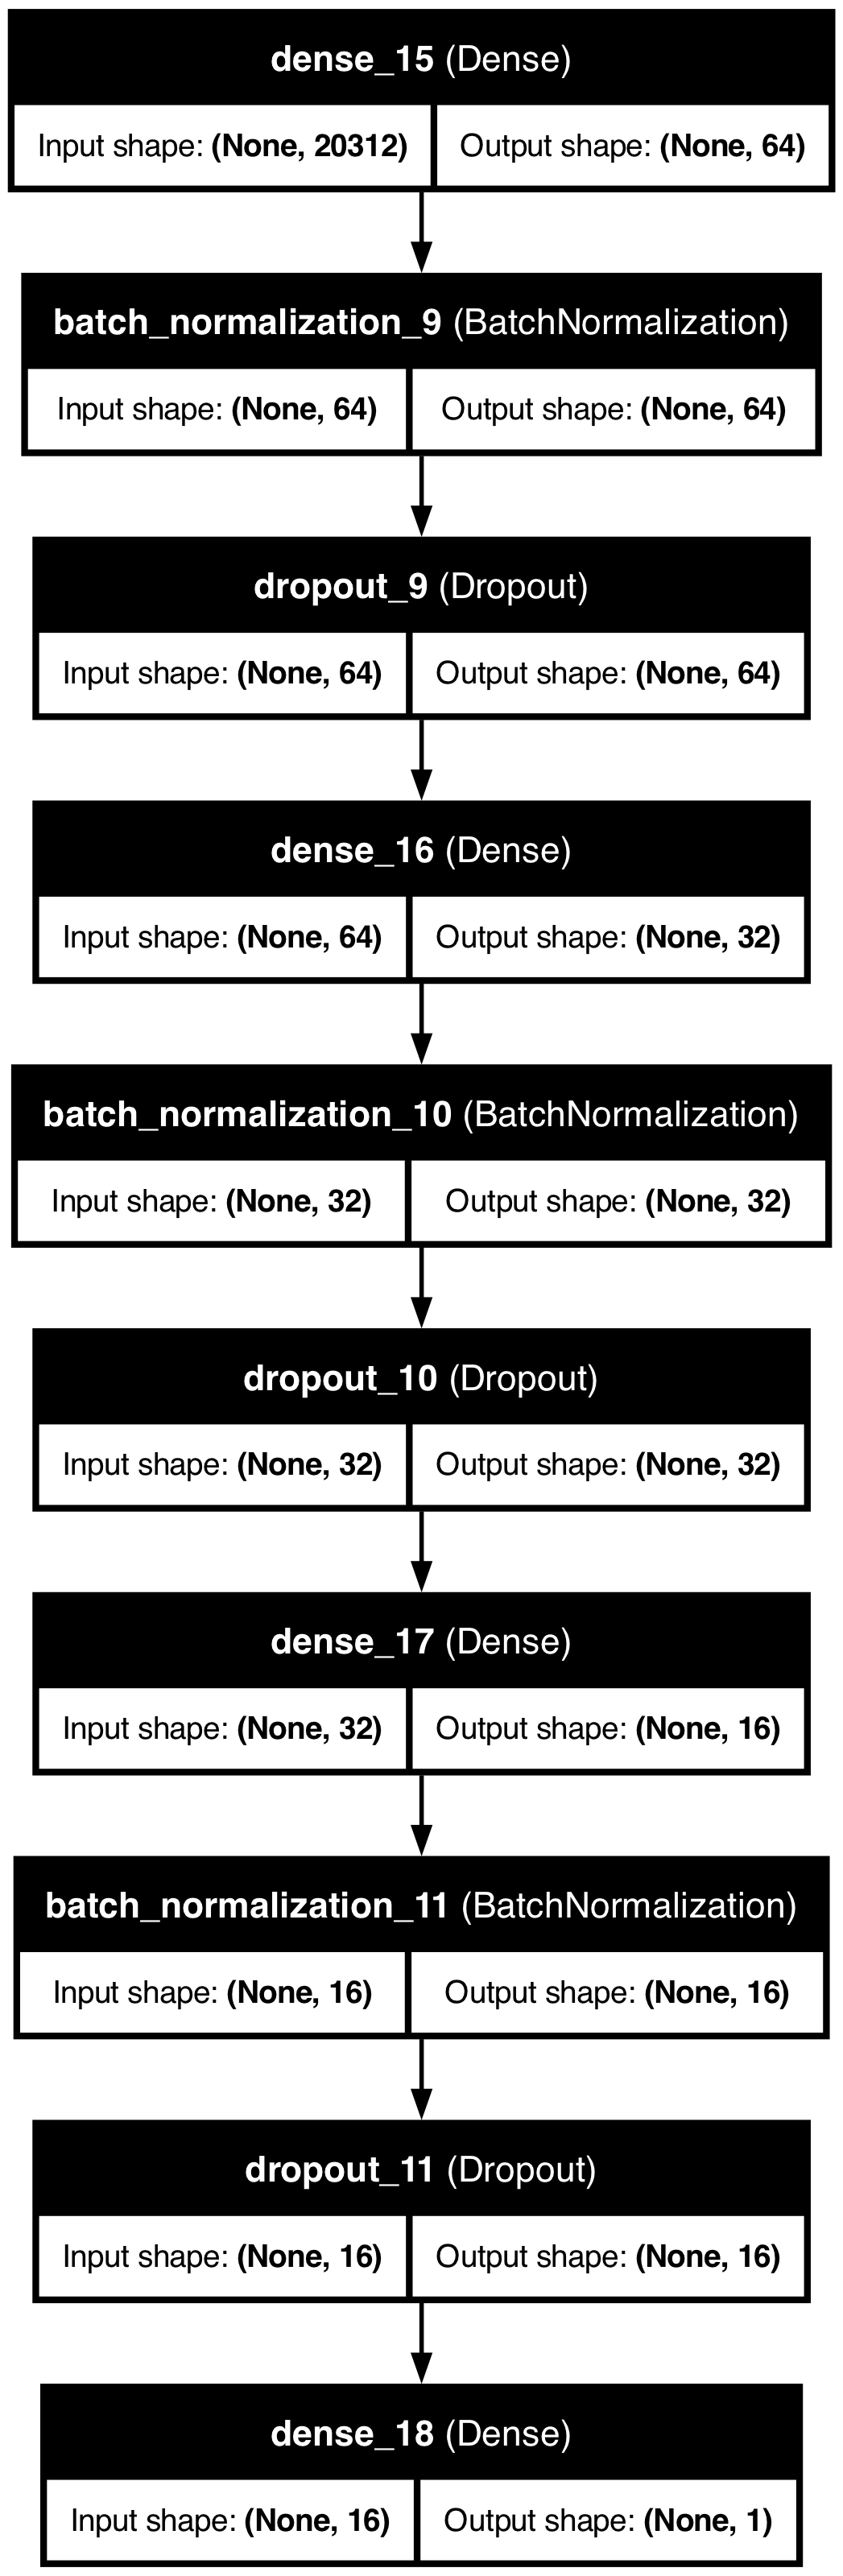

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt

csv12 = '/Users/schoudhry/Desktop/IIT/Research/researchData/StableS12.csv'
csv13 = '/Users/schoudhry/Desktop/IIT/Research/researchData/Stable13.csv'
csv1 = '/Users/schoudhry/Desktop/IIT/Research/researchData/Stable1.csv'

data_s12 = pd.read_csv(csv12)
data_s13 = pd.read_csv(csv13)
data_s1 = pd.read_csv(csv1)

genes_data = data_s12.rename(columns={'Unnamed: 0': 'Gene'})
all_patients_genes = genes_data.columns[1:]

bacteria_data = data_s13.rename(columns={'Unnamed: 0': 'Bacteria'})
all_patients_bacteria = bacteria_data.columns[1:]

crc_status = data_s1[['Tissue.RNA.DNA_Tube_ID', 'Description']]
crc_status['Tissue.RNA.DNA_Tube_ID'] = crc_status['Tissue.RNA.DNA_Tube_ID'].str.replace(' ', '')
crc_status['CRC_Status'] = crc_status['Description'].apply(lambda x: 1 if x == 'tumor' else 0)

merged_data = pd.concat([genes_data.set_index('Gene').T, bacteria_data.set_index('Bacteria').T], axis=1)
crc_status.index = crc_status['Tissue.RNA.DNA_Tube_ID']
merged_data = merged_data.merge(crc_status.set_index('Tissue.RNA.DNA_Tube_ID'), left_index=True, right_index=True)

# Convert all columns to numeric and handle NaNs
merged_data = merged_data.apply(pd.to_numeric, errors='coerce')
merged_data.fillna(0, inplace=True)

# Step 6: Prepare the input features (X) and target (y)
X = merged_data.drop(columns=['CRC_Status', 'Description']).values
y = merged_data['CRC_Status'].values

# Step 7: Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = X_scaled.astype(np.float32)
y = y.astype(np.float32)

# Step 8: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Step 9: Define the neural network model based on the diagram
model = tf.keras.Sequential([
    layers.InputLayer(input_shape=(X_train.shape[1],)),
    
    # First Hidden Layer
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    
    # Second Hidden Layer
    layers.Dense(32, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    
    # Third Hidden Layer
    layers.Dense(16, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    
    # Output Layer with one node for binary classification
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f"Test Accuracy: {test_accuracy:.4f}")

plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Confusion Matrix -> check if loading ??
y_pred = (model.predict(X_test) > 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Tumor'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

fpr, tpr, _ = roc_curve(y_test, model.predict(X_test))
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

from IPython.display import Image # working ????
Image('model_architecture.png')
# update

/Users/schoudhry/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


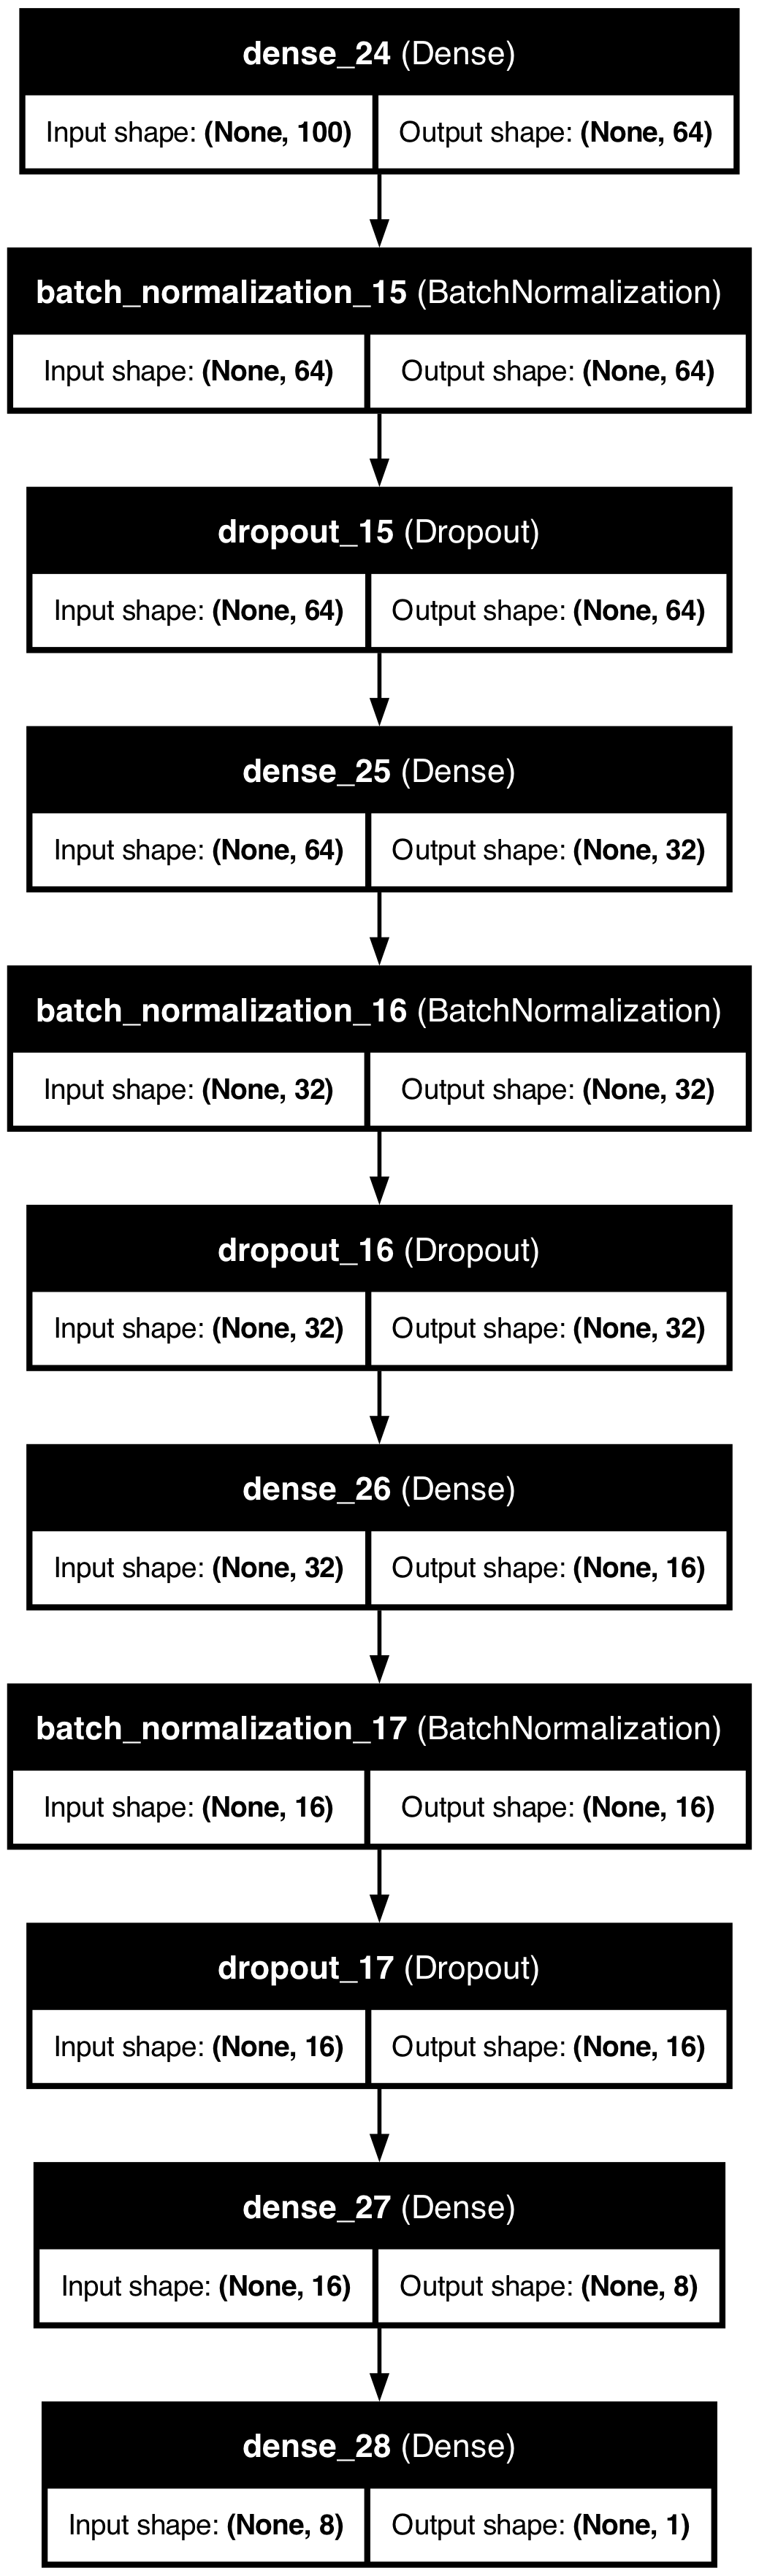

In [ ]:
from tensorflow.keras import layers, Sequential
from tensorflow.keras.utils import plot_model

# new netowrk 
# Define the updated new neural network model to match the original, adding in 4 dense layers (aiming for cross relation)
model = Sequential([
    layers.InputLayer(input_shape=(100,)),  # Adjust input shape as needed, try and optimize 

    # First Dense Layer
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    # Second Dense Layer
    layers.Dense(32, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    # Third Dense Layer
    layers.Dense(16, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    # Fourth Dense Layer
    layers.Dense(8, activation='relu'),

    # Output Layer for binary classification
    layers.Dense(1, activation='sigmoid')
])

# Save the model architecture as an image
plot_model(model, to_file='updated_model_architecture.png', show_shapes=True, show_layer_names=True)
